In [1]:
import pandas as pd

from config import BASE_DIR

BASELINE_DIR = f"{BASE_DIR}/experiments/baselines"
BASELINE_GNN_DIR = f"{BASE_DIR}/experiments/gnn/gcn_init"


In [2]:
import os


def list_files(dir):
    filenames = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            filenames.append(file)
    return filenames


print(list_files(BASELINE_DIR))
print(list_files(BASELINE_GNN_DIR))

['dataset_scroll.pkl', 'processed_vectorizers.pkl', 'dataset_composition.pkl', 'composition_unsupervised.csv', 'section_supervised.csv', 'section_unsupervised.csv', 'book_unsupervised.csv', 'composition_supervised.csv', 'book_supervised.csv', 'dataset_sectarian.pkl', 'datasets.pkl']
['gcn_init_section_2_adj_types.csv', 'gcn_init_composition_2_adj_types.csv', 'gcn_init_book_2_adj_types.csv']


In [3]:
tasks = ["composition", "section", "book"]
gnn_name_fomrat = "gcn_init_{}_2_adj_types.csv"

compare_list = {"book": [f"{BASELINE_DIR}/book_supervised.csv", f"{BASELINE_GNN_DIR}/{gnn_name_fomrat.format('book')}"],
                "composition": [f"{BASELINE_DIR}/composition_supervised.csv",
                                f"{BASELINE_GNN_DIR}/{gnn_name_fomrat.format('composition')}"],
                "section": [f"{BASELINE_DIR}/section_supervised.csv",
                            f"{BASELINE_GNN_DIR}/{gnn_name_fomrat.format('section')}"]}

In [4]:

COMPARISON_SCHEME = ["task", "model", "vectorizer", "test_acc", "weighted_f1", "micro_f1", "macro_f1", "adj_type"]

In [5]:

results = []
for task in tasks:
    baseline = pd.read_csv(compare_list[task][0])
    baseline = baseline.rename(columns={"accuracy": "test_acc"})
    baseline = baseline[baseline["model"].isin(["LogisticRegression", "MLPClassifier"])]
    baseline = baseline.sort_values(by="test_acc", ascending=False)
    baseline["task"] = task
    baseline["adj_type"] = None
    results.append(baseline[COMPARISON_SCHEME].to_dict(orient="records"))

    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    max_idx = gnn.groupby('vectorizer')['val_acc'].idxmax()
    max_test_acc_rows = gnn.loc[max_idx]
    max_test_acc_rows["model"] = "GCN"
    max_test_acc_rows["task"] = task
    results.append(max_test_acc_rows[COMPARISON_SCHEME].to_dict(orient="records"))

all_results = pd.DataFrame([item for sublist in results for item in sublist])
all_results

,task,model,vectorizer,test_acc,weighted_f1,micro_f1,macro_f1,adj_type
0,composition,MLPClassifier,dicta-il/BEREL,0.768730,0.747661,0.768730,0.566354,None
1,composition,MLPClassifier,dicta-il/dictabert,0.765472,0.746068,0.765472,0.602261,None
2,composition,MLPClassifier,yonatanlou/BEREL-finetuned-DSS-maskedLM,0.762215,0.738785,0.762215,0.547299,None
3,composition,MLPClassifier,trigram,0.758958,0.717849,0.758958,0.518262,None
4,composition,LogisticRegression,trigram,0.758958,0.726754,0.758958,0.548942,None
...,...,...,...,...,...,...,...,...
67,book,GCN,dicta-il/dictabert,0.694006,0.648794,0.694006,0.542330,tfidf
68,book,GCN,onlplab/alephbert-base,0.706625,0.670602,0.706625,0.575089,tfidf
69,book,GCN,yonatanlou/BEREL-finetuned-DSS-maskedLM,0.709779,0.671182,0.709779,0.568800,tfidf
70,book,GCN,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,0.709779,0.667449,0.709779,0.568579,tfidf


In [6]:
for task in all_results['task'].unique():
    tmp = all_results[all_results['task'] == task].sort_values(by="test_acc", ascending=False).head(20)
    # tmp.to_csv(f"{BASE_DIR}/reports/tables/{task}_classification_top_20.csv", index=False)


In [7]:

def get_group_by_vectorizer(i):
    if "yonatanlou" in i:
        return 'fine_tuned'
    elif "dicta" in i or "onlplab" in i:
        return 'pre_trained_bert'
    else:
        return 'classic_text_features'


all_results["vectorizer_type"] = all_results["vectorizer"].apply(get_group_by_vectorizer)



In [8]:

def generate_color_map(df, col, group_name, base_color="PuOr", base_color_by_group=None):
    groups = df.groupby(group_name)[col].apply(list).to_dict()
    num_groups = df[col].nunique()
    all_colors = list(sns.color_palette(base_color, num_groups))
    color_map = {}
    i = 0
    if not base_color_by_group:
        for group, items in groups.items():
            items = list(set(items))

            for item in items:
                color_map[item] = all_colors[i]
                i += 1
        return color_map

    # Function to generate shades of a base color
    def generate_shades(base_color, num_shades):
        # return sns.hls_palette(num_shades, h=base_color, l=0.5, s=0.5)

        return sns.color_palette(base_color, n_colors=num_shades + 1)

    # Create the color map
    color_map = {}
    for group, items in groups.items():
        shades = generate_shades(base_color_by_group[group], len(items))
        for item, shade in zip(items, shades):
            color_map[item] = shade
    return color_map





In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

def generate_bar_plot(all_results, x_col, y_col, hue_col, vectorizer_type_col, color_map, filename,
                      which_hue_cols=False, base_color_by_group=None):
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(all_results['task'].unique()), ncols=1,
                             figsize=(12, 6 * len(all_results['task'].unique())), sharey=False)
    all_results['task'] = all_results['task'].replace("section", "sectarian")
    
    # Create a custom order based on base_color_by_group
    if base_color_by_group:
        custom_order = []
        for group in base_color_by_group.keys():
            group_items = all_results[all_results['vectorizer_type'] == group][hue_col].unique()
            custom_order.extend(group_items)
    else:
        custom_order = None
    
    # Generate colors for each group
    if base_color_by_group:
        group_colors = {}
        for group, cmap_name in base_color_by_group.items():
            cmap = plt.get_cmap(cmap_name)
            group_colors[group] = cmap(0.6)  # Use a specific point in the colormap
    
    for i, task in enumerate(all_results['task'].unique()):
        # Filter data for the current task
        task_data = all_results[all_results['task'] == task]
        if which_hue_cols is not None:
            task_data = task_data[task_data[hue_col].isin(which_hue_cols)]

        # Sort the data according to the custom order
        if custom_order:
            task_data[hue_col] = pd.Categorical(task_data[hue_col], categories=custom_order, ordered=True)
            task_data = task_data.sort_values(hue_col)

        # Create the plot with sorted bars
        ax = axes[i] if len(all_results['task'].unique()) > 1 else axes
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue_col, data=task_data, palette=color_map, hue_order=custom_order)
        ax.set_title(f'{y_col} by {hue_col} for {task}', fontsize=16)

        # Adjusting the y-axis limits
        min_y_col = task_data[y_col].min()
        max_y_col = task_data[y_col].max()
        padding = (max_y_col - min_y_col) * 0.1
        ax.set_ylim(min_y_col - padding, max_y_col + padding)

        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel(y_col, fontsize=14)
        ax.tick_params(axis='x', rotation=45)

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid(alpha=0.5)

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

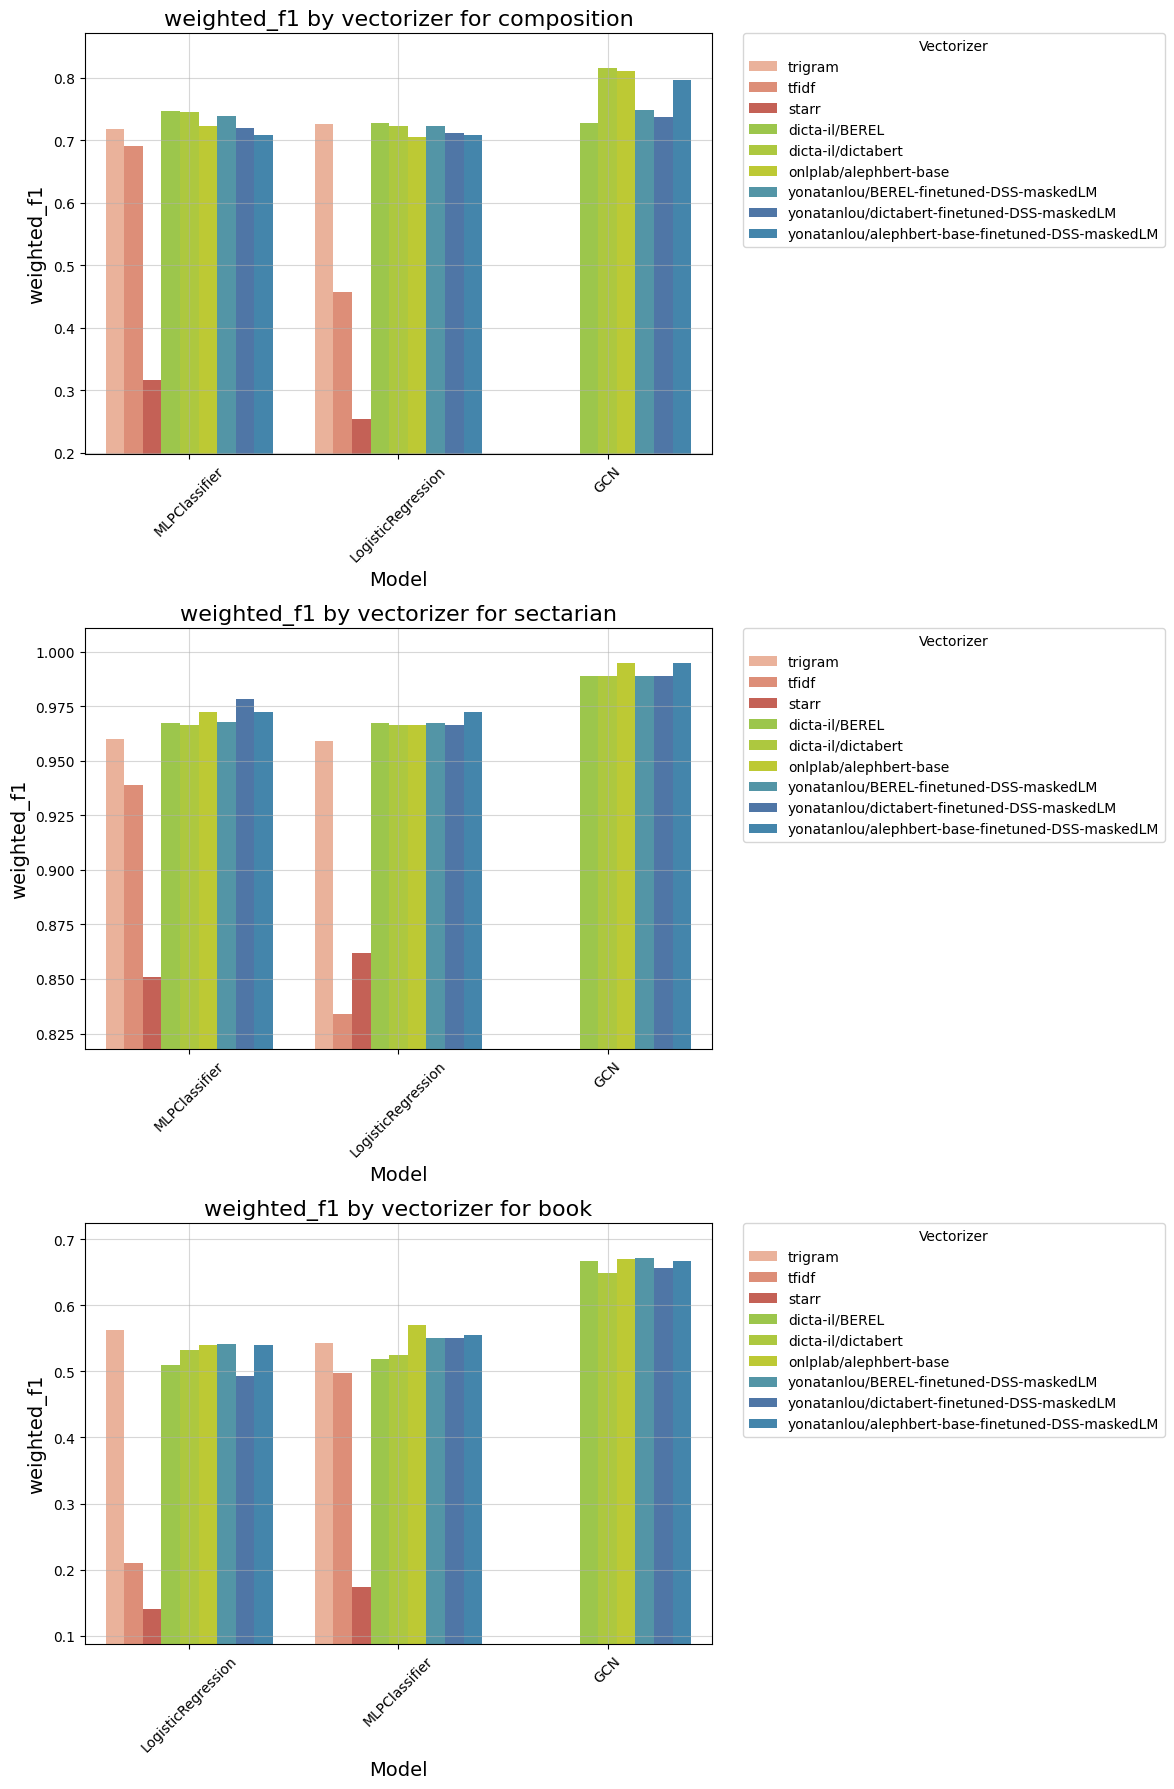

In [10]:
base_color_by_group = {
    'classic_text_features': "coolwarm",  # Red
    'pre_trained_bert': "viridis",  # Green
    'fine_tuned': "Spectral"  # Blue
}

color_map = generate_color_map(all_results, "vectorizer", "vectorizer_type", "RdYlGn", base_color_by_group)

file_name = f"{BASE_DIR}/experiments/gnn/comparsion_plot_all_tasks.png"
file_name = None
# hue_cols = list(all_results[all_results["model"]=="GCN"]["vectorizer"].unique())+["trigram"]
hue_cols = all_results["vectorizer"].unique()
plot_obj = generate_bar_plot(all_results, "model", "weighted_f1", "vectorizer", "vectorizer_type", color_map,
                             filename=file_name, which_hue_cols=hue_cols, base_color_by_group=base_color_by_group)

In [23]:

results_gnn = []
for task in tasks:
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    gnn["model"] = "GCN"
    gnn["task"] = task

    results_gnn.append(gnn.to_dict(orient="records"))

all_results_gnn = pd.DataFrame([item for sublist in results_gnn for item in sublist])
COMPARISON_SCHEME = ["task", "vectorizer", "model", "weighted_f1", "hidden_dim", "adj_type","learning_rate", "hidden_dim","epochs"]

MAIN_METRIC = "weighted_f1"
all_results_gnn[all_results_gnn["model"] == "GCN"].sort_values(by=MAIN_METRIC, ascending=False).groupby("task").head(
    5).sort_values(by=["task",MAIN_METRIC],ascending=False)[COMPARISON_SCHEME]


,task,vectorizer,model,weighted_f1,hidden_dim,adj_type,learning_rate,hidden_dim,epochs
61,section,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,GCN,0.994566,300,tfidf,0.001,300,500
60,section,onlplab/alephbert-base,GCN,0.994566,300,tfidf,0.001,300,500
64,section,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,GCN,0.989247,300,trigram & BOW-n_gram,0.001,300,500
66,section,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,GCN,0.989247,300,tfidf & trigram,0.001,300,500
67,section,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,GCN,0.989247,300,BOW-n_gram,0.001,300,500
0,composition,dicta-il/BEREL,GCN,0.824668,300,tfidf,0.001,300,500
3,composition,dicta-il/dictabert,GCN,0.815219,300,tfidf,0.001,300,500
2,composition,onlplab/alephbert-base,GCN,0.811715,300,tfidf,0.001,300,500
1,composition,yonatanlou/BEREL-finetuned-DSS-maskedLM,GCN,0.808794,300,tfidf,0.001,300,500
4,composition,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,GCN,0.796314,300,tfidf,0.001,300,500
